# ML Rank Histograms

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["image.origin"] = "lower"


Input a file path

In [2]:
source_paths = ["/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_12_26",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_14_15",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_17_09",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T11_55_23",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T13_30_38",
                "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/RankHistograms/2023-11-28T14_24_40"]

See the files in the directory

The different job result follow the output structure:
- Folders `0`, `1`, `6`, `12`, `24`, `27` for the different hours after spin-up
- Files `<n>_MLvalue_<l>.npy` where `n` is the experiment number and `l` is the level index (for higher levels it is succeeded by `_0` or `_1`)

In [3]:
fcount = 0
for f in os.listdir(os.path.join(source_paths[0], "0")):
    if f.startswith("0_"):
        fcount += 1

l_max = int((fcount-1)/2)

The data in the files has the shape $3 \times 24 \times N_e^l$ for all 3 variables and for all 24 locations 

Rank Histogram Utils

In [4]:
def loadMLvalues(source_path, T, n):
    MLvalues = []
    MLvalues.append(np.load(source_path+"/"+str(T)+"/"+str(n)+"_MLvalues_0.npy"))
    for l_idx in range(1, l_max+1):
        MLvalues.append([np.load(source_path+"/"+str(T)+"/"+str(n)+"_MLvalues_"+str(l_idx)+"_0.npy"),
                            np.load(source_path+"/"+str(T)+"/"+str(n)+"_MLvalues_"+str(l_idx)+"_1.npy")])
    return MLvalues

In [5]:
def loadTruth(source_path, T, n):
    return np.load(source_path+"/"+str(T)+"/"+str(n)+"_TRUEvalues.npy")

In [6]:
def MLrank(ensemble_values, true_values, R=None,
           func=lambda ensemble_values, true_values: 1*(ensemble_values < true_values)):
    # true reference
    true_values = true_values[:,:,np.newaxis]
    if R is not None:
        true_values += np.random.normal(0, R)

    if not isinstance(func, list):
        func = len(ensemble_values)*[[func,func,func]]

    # level 0 
    if R is not None:
        ensemble_values[0] += np.random.multivariate_normal(np.zeros(3), np.diag(R), size=ensemble_values[0].shape[-1]).T

    ML_Fy = np.zeros((3,ensemble_values[0].shape[-2]))
    for i in range(3):
        ML_Fy[i] = 1/(ensemble_values[0].shape[-1])*np.sum(func[0][i](ensemble_values[0][i], true_values[i]), axis=-1)

    # higher levels
    for l_idx in range(1, len(ensemble_values)):
        ensemble_values0 = ensemble_values[l_idx][0]
        ensemble_values1 = ensemble_values[l_idx][1]

        if R is not None:
            lvl_perts = np.random.multivariate_normal(np.zeros(3), np.diag(R), size=len(ensemble_values0)).T
            ensemble_values0 += lvl_perts
            ensemble_values1 += lvl_perts

        for i in range(3):
            ML_Fy[i] += 1/(ensemble_values0.shape[-1]) * \
                                        np.sum( func[l_idx][i](ensemble_values0[i], true_values[i]) 
                                        - func[l_idx][i](ensemble_values1[i], true_values[i]),
                                            axis=-1 )
        
    return ML_Fy

### Direct Evaluation

In [7]:
def MLranks4T(T):
    MLranks = np.array([]).reshape(0,3)
    for p in range(len(source_paths)):
        for n in range(50):
            try: 
                MLensemble = loadMLvalues(source_paths[p], T, n)
                truth = loadTruth(source_paths[p], T, n)
                
                MLranks = np.vstack([MLranks, MLrank(MLensemble, truth).T]) 
            except:
                pass
    
    return MLranks

In [8]:
MLranks = MLranks4T(27)

In [31]:
c0 = (0, 68/255, 136/255)

In [53]:
np.arange(xlim[0],xlim[1]+1e-9, 0.05)

array([-2.50000000e-01, -2.00000000e-01, -1.50000000e-01, -1.00000000e-01,
       -5.00000000e-02, -5.55111512e-17,  5.00000000e-02,  1.00000000e-01,
        1.50000000e-01,  2.00000000e-01,  2.50000000e-01,  3.00000000e-01,
        3.50000000e-01,  4.00000000e-01,  4.50000000e-01,  5.00000000e-01,
        5.50000000e-01,  6.00000000e-01,  6.50000000e-01,  7.00000000e-01,
        7.50000000e-01,  8.00000000e-01,  8.50000000e-01,  9.00000000e-01,
        9.50000000e-01,  1.00000000e+00,  1.05000000e+00,  1.10000000e+00,
        1.15000000e+00,  1.20000000e+00,  1.25000000e+00])

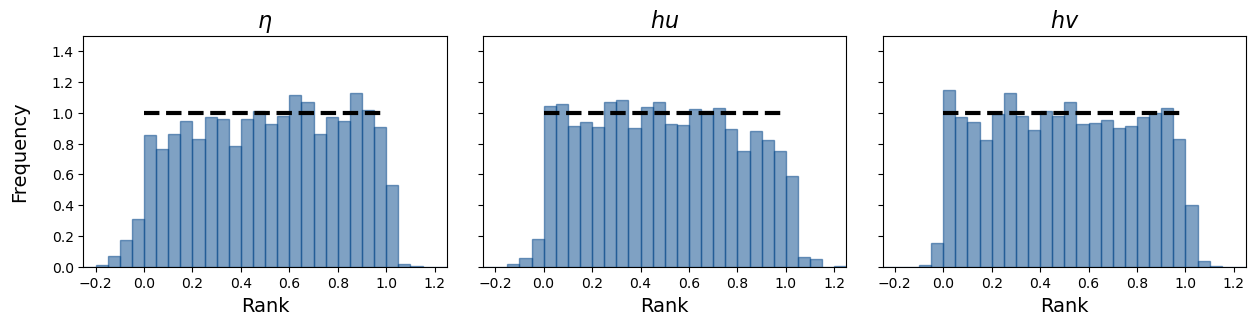

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(15,3), sharey=True, gridspec_kw={'wspace': 0.1})

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].yaxis.set_label_coords(-.15, .5)

xlim = (-0.25,1.25)
bins_size = 0.05
bins = np.arange(xlim[0],xlim[1]+1e-9, bins_size)

for i in range(3):
    ranks = np.maximum(xlim[0], MLranks[:,i])
    ranks = np.minimum(ranks, xlim[1])
    hist = np.histogram(ranks, bins=bins)
    
    axs[i].bar(0.5*(hist[1][1:]+hist[1][:-1]), hist[0]/len(MLranks[:,i])/bins_size, 
               width=bins_size, 
               color=c0, alpha=0.5, edgecolor=c0)
    
    axs[i].set_ylim((0,1.5))
    axs[i].set_xlim(xlim)

    axs[i].plot([0,1],[1,1], color="black", ls="--", lw=3)

    axs[i].set_xlabel('Rank', fontsize=14)

plt.savefig("DoubleJet-MLRanks-PostProcessing4paper.pdf", bbox_inches="tight", dpi=300)